In [1]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import hdbscan
import string


from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import torch
import torch.nn as nn
from radam import RAdam
from optimizer import Lookahead

import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
%matplotlib inline

import shap
shap.initjs()

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
FEATS = 20
features, output, coef = make_regression(n_samples = 1000,
                                         # three features
                                         n_features = FEATS,
                                         # where only two features are useful,
                                         n_informative = 15,
                                         # a single target value per observation
                                         n_targets = 1,
                                         # 0.0 standard deviation of the guassian noise
                                         noise = 0.1,
                                         # show the true coefficient used to generated the data
                                         coef = True)

In [3]:
coef

array([ 4.90975924,  0.        , 73.81356973, 96.75109885, 91.70833366,
        0.        , 64.50963207, 54.78518812, 87.38076065,  0.        ,
        2.40660169, 78.55862   , 79.34677311, 48.28982472,  0.        ,
        0.        ,  5.40944198,  6.79676303, 38.03302972, 72.89868337])

In [4]:
scaled_coef = (coef - coef.min())/(coef.max()-coef.min())

In [5]:
alphabet_list = list(string.ascii_lowercase)
column_names = np.array(alphabet_list[0:FEATS])
df_features = pd.DataFrame(features, columns=column_names)

In [6]:
df_output = pd.DataFrame(output, columns=['output'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features, output, test_size=0.2,
    shuffle=True ,random_state=42)

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [9]:
rf_regr = RandomForestRegressor(max_depth=7, n_estimators=700)
rf_regr.fit(X_train, y_train)
rf_predicted = rf_regr.predict(X_test)

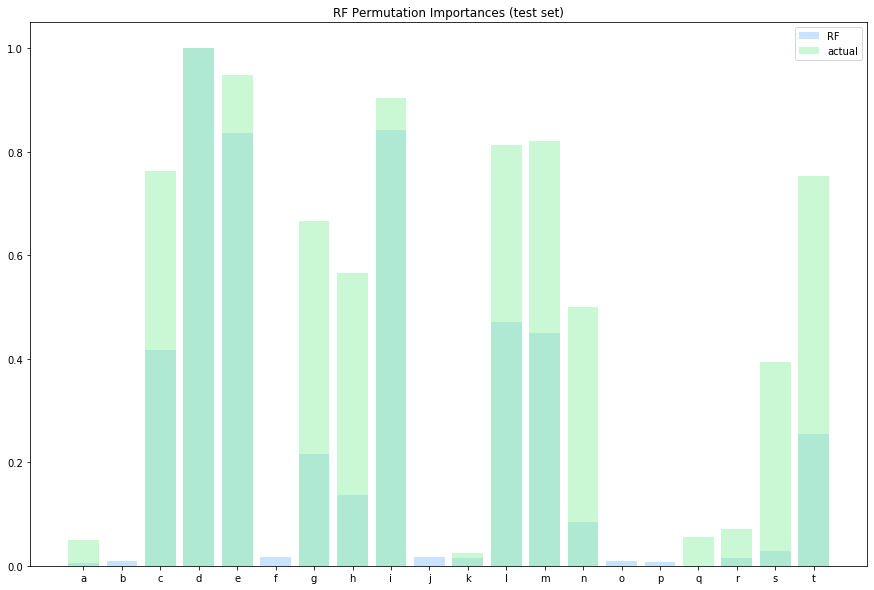

In [10]:
pi_result_rf = permutation_importance(rf_regr, X_test, y_test, n_repeats=10,
                                random_state=42, scoring = mae_scorer)


pi_result_rf_scaled = (pi_result_rf.importances_mean - pi_result_rf.importances_mean.min())/(pi_result_rf.importances_mean.max()-pi_result_rf.importances_mean.min())
pos = np.arange(column_names.size)
plt.figure(figsize=(15,10))
plt.bar(pos,pi_result_rf_scaled,align='center', alpha=0.5, label='RF')
plt.bar(pos,scaled_coef,align='center', alpha=0.5, label='actual')
plt.xticks(pos, column_names)
plt.title("RF Permutation Importances (test set)")
#plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

In [11]:
gb_regr = GradientBoostingRegressor(max_depth=5, n_estimators=500)
gb_regr.fit(X_train, y_train)
gb_predicted = gb_regr.predict(X_test)

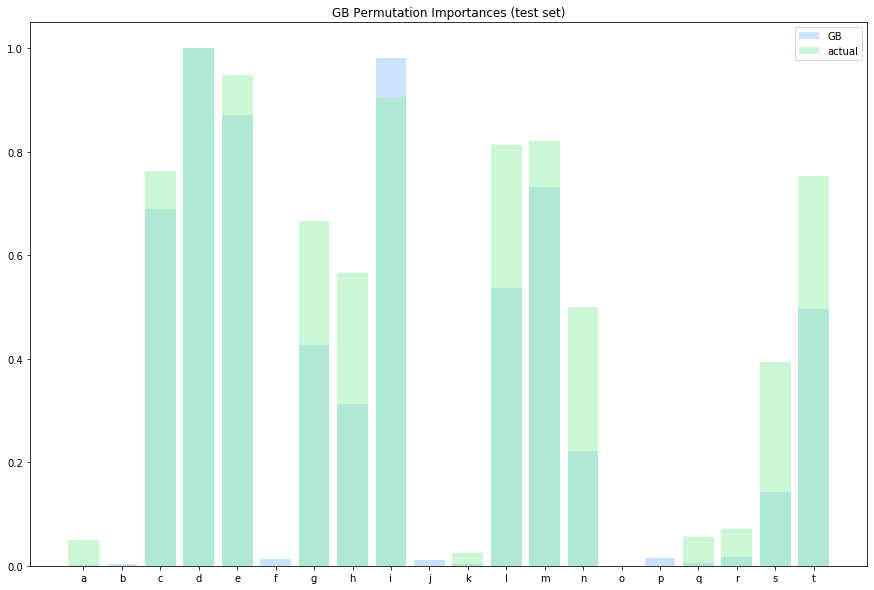

In [12]:
pi_result_gb = permutation_importance(gb_regr, X_test, y_test, n_repeats=10,
                                random_state=42, scoring = mae_scorer)

pi_result_gb_scaled = (pi_result_gb.importances_mean - pi_result_gb.importances_mean.min())/(pi_result_gb.importances_mean.max()-pi_result_gb.importances_mean.min())
pos = np.arange(column_names.size)
plt.figure(figsize=(15,10))
plt.bar(pos,pi_result_gb_scaled,align='center', alpha=0.5, label='GB')
plt.bar(pos,scaled_coef,align='center', alpha=0.5, label='actual')
plt.xticks(pos, column_names)
plt.title("GB Permutation Importances (test set)")
#plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

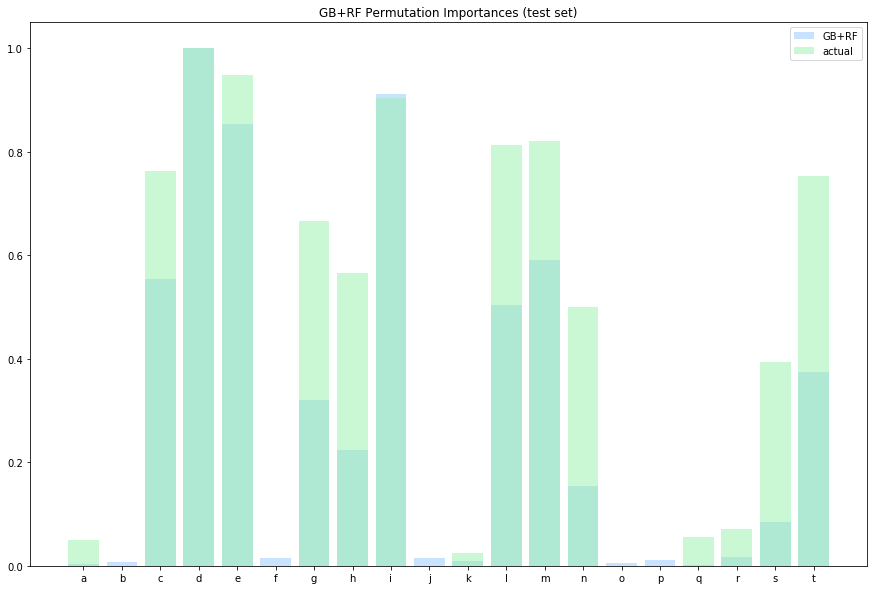

In [13]:
pos = np.arange(column_names.size)
plt.figure(figsize=(15,10))
plt.bar(pos,(pi_result_gb_scaled+pi_result_rf_scaled)/2,align='center', alpha=0.5, label='GB+RF')
plt.bar(pos,scaled_coef,align='center', alpha=0.5, label='actual')
plt.xticks(pos, column_names)
plt.title("GB+RF Permutation Importances (test set)")
#plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()

In [14]:
print(f'GB predicted error: {np.abs(gb_predicted - y_test).mean()}')

GB predicted error: 79.1777575518397


In [15]:
print(f'RF predicted error: {np.abs(rf_predicted - y_test).mean()}')

RF predicted error: 116.49191814833543


In [16]:
print(f'RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}')
print(f'GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}')
print(f'RF+GB PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')

RF PI error: 0.18098418192037496
GB PI error: 0.10442549262875929
RF+GB PI error: 0.13964455441937285


In [17]:
explainer_rf = shap.TreeExplainer(rf_regr)
shap_values_rf = explainer_rf.shap_values(df_features)

explainer_gb = shap.TreeExplainer(gb_regr)
shap_values_gb = explainer_gb.shap_values(df_features)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [18]:
gb_sv = np.abs(shap_values_gb).mean(0)
gb_sv_min = np.abs(shap_values_gb).mean(0).min()
gb_sv_max = np.abs(shap_values_gb).mean(0).max()

gb_sv_scaled = (gb_sv-gb_sv_min)/(gb_sv_max-gb_sv_min)


rf_sv = np.abs(shap_values_rf).mean(0)
rf_sv_min = np.abs(shap_values_rf).mean(0).min()
rf_sv_max = np.abs(shap_values_rf).mean(0).max()

rf_sv_scaled = (rf_sv-rf_sv_min)/(rf_sv_max-rf_sv_min)

In [19]:
print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
print(f'GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}')
print(f'RF+GB SV error: {np.abs(((gb_sv_scaled+rf_sv_scaled)/2) - scaled_coef).mean()}')
print('')
print(f'GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}')
print(f'GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}')
print(f'GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}')
print('')
print(f'RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}')
print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
print(f'RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')
print('')
total_pi_sv_scaled = ((rf_sv_scaled+pi_result_rf_scaled+gb_sv_scaled+pi_result_gb_scaled)/4)
print(f'(RF PI + RF SV) + (GB PI + GB SV) error: {np.abs(total_pi_sv_scaled - scaled_coef).mean()}')

RF SV error: 0.18050834184051195
GB SV error: 0.0783514172822242
RF+GB SV error: 0.1294298795613681

GB PI error: 0.10442549262875929
GB SV error: 0.0783514172822242
GB PI + GB SV error: 0.08778384907015697

RF PI error: 0.18098418192037496
RF SV error: 0.18050834184051195
RF PI + RF SV error: 0.18074626188044346

(RF PI + RF SV) + (GB PI + GB SV) error: 0.13414398035947034


# DNN

In [20]:
y_test.shape

(200,)

In [21]:
class SimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
#         self.linear1 = nn.Linear(20, 128)
#         self.relu1 = nn.ReLU()
        
#         self.linear2 = nn.Linear(128, 256)
#         self.relu2 = nn.ReLU()
        
#         self.linear3 = nn.Linear(256, 128)
#         self.relu3 = nn.ReLU()
        
#         self.linear4 = nn.Linear(128, 64)
#         self.relu4 = nn.ReLU()
        
        self.linear5 = nn.Linear(FEATS, 64)
        self.relu5 = nn.Tanh()
        
        self.linear6 = nn.Linear(64, 32)
        self.relu6 = nn.Tanh()
        
        self.linear7 = nn.Linear(32, 16)
        self.relu7 = nn.Tanh()
        
        self.linear8 = nn.Linear(16, 8)
        self.relu8 = nn.Tanh()
        
        self.linear9 = nn.Linear(8, 6)
        self.relu9 = nn.Tanh()
        
        self.linear10 = nn.Linear(6, 4)
        self.relu10 = nn.Tanh()
        
        self.linear11 = nn.Linear(4, 1)
        #self.relu11 = nn.ReLU()

    def forward(self, x):
#         x = self.relu1(self.linear1(x))
#         x = self.relu2(self.linear2(x))
#         x = self.relu3(self.linear3(x))
#         x = self.relu4(self.linear4(x))
        x = self.relu5(self.linear5(x))
        x = self.relu6(self.linear6(x))
        x = self.relu7(self.linear7(x))
        x = self.relu8(self.linear8(x))
        x = self.relu9(self.linear9(x))
        x = self.relu10(self.linear10(x))
        x = self.linear11(x)
        return x
    
from radam import RAdam
from optimizer import Lookahead
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
net = SimpleNNModel()
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
net.apply(init_weights)

USE_PRETRAINED_MODEL = False
n_batches = 32
if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('interpret_model.pt'))
    print("Model Loaded!")
else:
    criterion = nn.MSELoss()
    num_epochs = 600

    #optimizer = torch.optim.AdamW(net.parameters(), lr=0.0003, weight_decay=0.01)
    base_optim = RAdam(net.parameters(),lr = 0.01) 
    optimizer =  Lookahead(base_optim, k=6, alpha=0.5)
    input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(y_train).type(torch.FloatTensor)
    for epoch in range(num_epochs):
        for i in range(n_batches):
            local_X, local_y = input_tensor[i*n_batches:(i+1)*n_batches,], label_tensor[i*n_batches:(i+1)*n_batches,]
            output = net(input_tensor)
            loss = criterion(output, label_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print ('Epoch {}/{} => Loss: {:.6f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'interpret_model.pt')

Epoch 1/600 => Loss: 59395.613281
Epoch 11/600 => Loss: 58497.839844
Epoch 21/600 => Loss: 57275.523438
Epoch 31/600 => Loss: 55861.246094
Epoch 41/600 => Loss: 54280.546875
Epoch 51/600 => Loss: 52612.808594
Epoch 61/600 => Loss: 50928.964844
Epoch 71/600 => Loss: 49191.804688
Epoch 81/600 => Loss: 47453.179688
Epoch 91/600 => Loss: 45757.718750
Epoch 101/600 => Loss: 44055.156250
Epoch 111/600 => Loss: 42385.464844
Epoch 121/600 => Loss: 40783.980469
Epoch 131/600 => Loss: 39189.218750
Epoch 141/600 => Loss: 37638.480469
Epoch 151/600 => Loss: 36163.824219
Epoch 161/600 => Loss: 34707.046875
Epoch 171/600 => Loss: 33299.324219
Epoch 181/600 => Loss: 31964.974609
Epoch 191/600 => Loss: 30649.318359
Epoch 201/600 => Loss: 29379.554688
Epoch 211/600 => Loss: 28190.572266
Epoch 221/600 => Loss: 26977.794922
Epoch 231/600 => Loss: 25832.501953
Epoch 241/600 => Loss: 24744.890625
Epoch 251/600 => Loss: 23680.347656
Epoch 261/600 => Loss: 22657.318359
Epoch 271/600 => Loss: 21692.820312
Epo

In [22]:
test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
test_output = net(test_input_tensor).detach().numpy()
print("Test MSE:", np.sqrt((np.abs(test_output - y_test)).mean()))

Test MSE: 8.087385055333602


In [23]:
ig = IntegratedGradients(net)
test_input_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

feature_names = list(column_names)

Intergrated Gradient Average Feature Importances
a :  -2.157
b :  -0.143
c :  -5.223
d :  -3.228
e :  0.324
f :  0.551
g :  -2.971
h :  -1.175
i :  -14.932
j :  -0.229
k :  1.346
l :  -23.975
m :  -4.163
n :  -1.354
o :  3.364
p :  -0.270
q :  -1.491
r :  -4.442
s :  -1.029
t :  -4.197


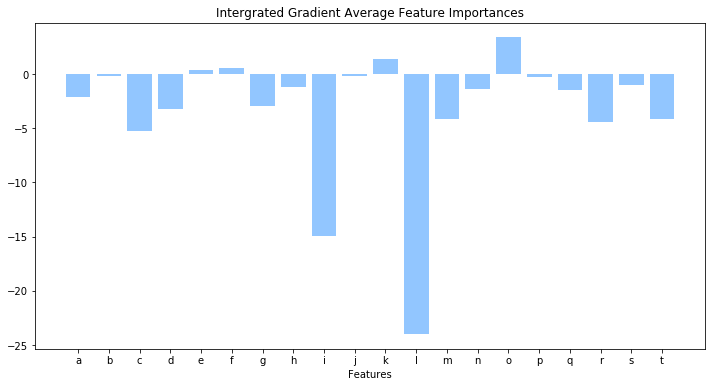

In [24]:
def visualize_importances(feature_names, importances, title="Intergrated Gradient Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=False)
        plt.xlabel(axis_title)
        plt.title(title)
        
visualize_importances(column_names, np.mean(attr, axis=0))

In [25]:
dnn_ig = np.abs(np.mean(attr, axis=0))
dnn_ig = np.abs(dnn_ig)
dnn_ig_min = np.abs(dnn_ig).min()
dnn_ig_max = np.abs(dnn_ig).max()

dnn_ig_scaled = (dnn_ig-dnn_ig_min)/(dnn_ig_max-dnn_ig_min)
dnn_ig_scaled

array([0.0845084 , 0.        , 0.21317135, 0.12946376, 0.00760346,
       0.01712285, 0.11865887, 0.04331153, 0.6205206 , 0.00359917,
       0.05047629, 1.        , 0.16866662, 0.05082996, 0.13515303,
       0.00533828, 0.05655567, 0.18039042, 0.03718514, 0.17011628],
      dtype=float32)

In [26]:
print(f'DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}')
# print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
# print(f'RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')

DNN IG error: 0.3136311047974877


In [27]:
def base_model():
    model = tf.keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(X_train.shape[1],),bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(64, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(32, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(16, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(8, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(6, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(4, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='linear')])

    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    #tf.keras.optimizers.Adam(1e-4)
    # Configure a model for mean-squared error regression.
    model.compile(optimizer=ranger,
                  loss='mse',       # mean squared error
                  metrics=['mae'])  # mean absolute error

    return model



# reshape for deep model
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

dnn_model = KerasRegressor(build_fn=base_model,
                          epochs=1000,
                          batch_size=32,
                          verbose=1,
                          validation_split = 0.1,
                          callbacks = [callback])  

history  = dnn_model.fit(X_train, y_train)
perm = PermutationImportance(dnn_model, scoring=mae_scorer, random_state=1).fit(X_train, y_train);
dnn_pi_df = eli5.explain_weights_df(perm, feature_names = column_names.tolist())

Train on 720 samples, validate on 80 samples
Epoch 1/1000
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
720/720 [==============================] - 5s 7ms/sample - loss: 61880.0703 - mae: 197.7667 - val_loss: 49713.6426 - val_mae: 188.5110
Epoch 2/1000
720/720 [==============================] - 0s 300us/sample - loss: 61752.7949 - mae: 197.4896 - val_loss: 49692.0301 - val_mae: 188.4456
Epoch 3/1000
720/720 [==============================] - 0s 231us/sample - loss: 61727.8411 - mae: 197.4045 - val_loss: 49650.6699 - val_mae: 188.3390
Epoch 4/1000
720/720 [==============================] - 0s 224us/sample - loss: 61705.6497 - mae: 197.3204 - val_loss: 49612.1910 - val_mae: 188.2340
Epoch 5/1000
720/720 [==============================] - 0s 244us/sample - loss: 61684.6733 - mae: 197.2407 - val_loss: 49590.5297 - val_mae: 188.1555
Epoch 6/1000
720/720 [==============================] - 0s 231us/sample - loss: 61662.1969 - mae: 197.1544 - val_loss: 49574.2

720/720 [==============================] - 0s 202us/sample - loss: 60967.9655 - mae: 194.7936 - val_loss: 48967.4012 - val_mae: 186.3080
Epoch 53/1000
720/720 [==============================] - 0s 218us/sample - loss: 60954.3224 - mae: 194.7592 - val_loss: 48954.8203 - val_mae: 186.2754
Epoch 54/1000
720/720 [==============================] - 0s 205us/sample - loss: 60940.5448 - mae: 194.7223 - val_loss: 48942.1992 - val_mae: 186.2375
Epoch 55/1000
720/720 [==============================] - 0s 212us/sample - loss: 60926.9415 - mae: 194.6846 - val_loss: 48926.1258 - val_mae: 186.1950
Epoch 56/1000
720/720 [==============================] - 0s 206us/sample - loss: 60913.1007 - mae: 194.6519 - val_loss: 48913.3047 - val_mae: 186.1587
Epoch 57/1000
720/720 [==============================] - 0s 197us/sample - loss: 60899.0127 - mae: 194.6161 - val_loss: 48900.7312 - val_mae: 186.1239
Epoch 58/1000
720/720 [==============================] - 0s 210us/sample - loss: 60885.1557 - mae: 194.5777 

720/720 [==============================] - 0s 205us/sample - loss: 60178.0556 - mae: 192.9883 - val_loss: 48204.1977 - val_mae: 184.2906
Epoch 107/1000
720/720 [==============================] - 0s 201us/sample - loss: 60162.1260 - mae: 192.9281 - val_loss: 48190.0582 - val_mae: 184.2544
Epoch 108/1000
720/720 [==============================] - 0s 202us/sample - loss: 60146.7807 - mae: 192.8790 - val_loss: 48186.4195 - val_mae: 184.4189
Epoch 109/1000
720/720 [==============================] - 0s 193us/sample - loss: 60128.4034 - mae: 192.7716 - val_loss: 48157.7742 - val_mae: 184.1378
Epoch 110/1000
720/720 [==============================] - 0s 204us/sample - loss: 60112.3392 - mae: 192.7242 - val_loss: 48142.4219 - val_mae: 184.0644
Epoch 111/1000
720/720 [==============================] - 0s 209us/sample - loss: 60095.0319 - mae: 192.6458 - val_loss: 48129.6418 - val_mae: 184.1841
Epoch 112/1000
720/720 [==============================] - 0s 192us/sample - loss: 60079.3521 - mae: 192

Epoch 160/1000
720/720 [==============================] - 0s 204us/sample - loss: 59305.4793 - mae: 190.7403 - val_loss: 47374.7324 - val_mae: 182.3212
Epoch 161/1000
720/720 [==============================] - 0s 221us/sample - loss: 59288.8434 - mae: 190.6999 - val_loss: 47359.6879 - val_mae: 182.2818
Epoch 162/1000
720/720 [==============================] - 0s 204us/sample - loss: 59272.2196 - mae: 190.6597 - val_loss: 47344.5262 - val_mae: 182.2422
Epoch 163/1000
720/720 [==============================] - 0s 194us/sample - loss: 59255.7802 - mae: 190.6190 - val_loss: 47325.3941 - val_mae: 182.1921
Epoch 164/1000
720/720 [==============================] - 0s 215us/sample - loss: 59239.2952 - mae: 190.5785 - val_loss: 47310.2348 - val_mae: 182.1525
Epoch 165/1000
720/720 [==============================] - 0s 196us/sample - loss: 59222.8736 - mae: 190.5378 - val_loss: 47295.0996 - val_mae: 182.1129
Epoch 166/1000
720/720 [==============================] - 0s 207us/sample - loss: 59206.

720/720 [==============================] - 0s 217us/sample - loss: 58424.5848 - mae: 188.5709 - val_loss: 46542.5285 - val_mae: 180.2255
Epoch 214/1000
720/720 [==============================] - 0s 200us/sample - loss: 58407.7853 - mae: 188.5289 - val_loss: 46527.0977 - val_mae: 180.1761
Epoch 215/1000
720/720 [==============================] - 0s 200us/sample - loss: 58390.9109 - mae: 188.4865 - val_loss: 46511.0188 - val_mae: 180.0499
Epoch 216/1000
720/720 [==============================] - 0s 201us/sample - loss: 58374.1569 - mae: 188.4365 - val_loss: 46496.1918 - val_mae: 180.0673
Epoch 217/1000
720/720 [==============================] - 0s 197us/sample - loss: 58357.6377 - mae: 188.4006 - val_loss: 46476.4715 - val_mae: 179.9875
Epoch 218/1000
720/720 [==============================] - 0s 200us/sample - loss: 58340.5950 - mae: 188.3476 - val_loss: 46461.6418 - val_mae: 179.9783
Epoch 219/1000
720/720 [==============================] - 0s 197us/sample - loss: 58324.1278 - mae: 188

Epoch 267/1000
720/720 [==============================] - 0s 184us/sample - loss: 57523.1418 - mae: 186.3453 - val_loss: 45688.4645 - val_mae: 178.1739
Epoch 268/1000
720/720 [==============================] - 0s 187us/sample - loss: 57507.0131 - mae: 186.3199 - val_loss: 45673.5074 - val_mae: 178.1382
Epoch 269/1000
720/720 [==============================] - 0s 193us/sample - loss: 57490.3063 - mae: 186.2715 - val_loss: 45658.1535 - val_mae: 178.0979
Epoch 270/1000
720/720 [==============================] - 0s 187us/sample - loss: 57473.9808 - mae: 186.2344 - val_loss: 45642.2895 - val_mae: 178.0502
Epoch 271/1000
720/720 [==============================] - 0s 196us/sample - loss: 57457.2244 - mae: 186.1951 - val_loss: 45605.0078 - val_mae: 177.6354
Epoch 272/1000
720/720 [==============================] - 0s 193us/sample - loss: 57439.9607 - mae: 186.1285 - val_loss: 45589.7063 - val_mae: 177.5940
Epoch 273/1000
720/720 [==============================] - 0s 184us/sample - loss: 57422.

Epoch 321/1000
720/720 [==============================] - 0s 189us/sample - loss: 56633.8119 - mae: 184.3165 - val_loss: 44834.0191 - val_mae: 175.9353
Epoch 322/1000
720/720 [==============================] - 0s 184us/sample - loss: 56614.6898 - mae: 184.1814 - val_loss: 44818.9402 - val_mae: 175.8952
Epoch 323/1000
720/720 [==============================] - 0s 185us/sample - loss: 56598.0600 - mae: 184.1384 - val_loss: 44804.1035 - val_mae: 175.8558
Epoch 324/1000
720/720 [==============================] - 0s 186us/sample - loss: 56581.7784 - mae: 184.1011 - val_loss: 44789.2277 - val_mae: 175.8162
Epoch 325/1000
720/720 [==============================] - 0s 189us/sample - loss: 56565.6373 - mae: 184.0691 - val_loss: 44770.0465 - val_mae: 175.7653
Epoch 326/1000
720/720 [==============================] - 0s 190us/sample - loss: 56548.9601 - mae: 184.0195 - val_loss: 44755.1465 - val_mae: 175.7257
Epoch 327/1000
720/720 [==============================] - 0s 297us/sample - loss: 56532.

720/720 [==============================] - 0s 195us/sample - loss: 55759.5496 - mae: 181.9987 - val_loss: 43986.4000 - val_mae: 173.2301
Epoch 375/1000
720/720 [==============================] - 0s 200us/sample - loss: 55743.0808 - mae: 181.9576 - val_loss: 43971.7312 - val_mae: 173.1896
Epoch 376/1000
720/720 [==============================] - 0s 190us/sample - loss: 55726.9097 - mae: 181.9156 - val_loss: 43956.5621 - val_mae: 173.1443
Epoch 377/1000
720/720 [==============================] - 0s 197us/sample - loss: 55710.5103 - mae: 181.8828 - val_loss: 43941.3629 - val_mae: 173.0946
Epoch 378/1000
720/720 [==============================] - 0s 187us/sample - loss: 55694.3411 - mae: 181.8443 - val_loss: 43926.4145 - val_mae: 173.0517
Epoch 379/1000
720/720 [==============================] - 0s 217us/sample - loss: 55678.1862 - mae: 181.8017 - val_loss: 43905.0543 - val_mae: 172.9297
Epoch 380/1000
720/720 [==============================] - 0s 182us/sample - loss: 55661.5207 - mae: 181

Epoch 428/1000
720/720 [==============================] - 0s 179us/sample - loss: 54880.4198 - mae: 179.5983 - val_loss: 43145.8371 - val_mae: 170.8000
Epoch 429/1000
720/720 [==============================] - 0s 180us/sample - loss: 54864.3444 - mae: 179.5583 - val_loss: 43130.5477 - val_mae: 170.7496
Epoch 430/1000
720/720 [==============================] - 0s 191us/sample - loss: 54848.0741 - mae: 179.5183 - val_loss: 43116.7754 - val_mae: 170.7288
Epoch 431/1000
720/720 [==============================] - 0s 185us/sample - loss: 54832.0671 - mae: 179.4798 - val_loss: 43102.1875 - val_mae: 170.6912
Epoch 432/1000
720/720 [==============================] - 0s 193us/sample - loss: 54816.0405 - mae: 179.4395 - val_loss: 43087.1348 - val_mae: 170.6401
Epoch 433/1000
720/720 [==============================] - 0s 204us/sample - loss: 54800.1366 - mae: 179.3976 - val_loss: 43068.7754 - val_mae: 170.6002
Epoch 434/1000
720/720 [==============================] - 0s 219us/sample - loss: 54783.

Epoch 482/1000
720/720 [==============================] - 0s 202us/sample - loss: 54013.8357 - mae: 177.2691 - val_loss: 42317.3777 - val_mae: 168.4002
Epoch 483/1000
720/720 [==============================] - 0s 225us/sample - loss: 53998.1009 - mae: 177.2296 - val_loss: 42313.5680 - val_mae: 168.6824
Epoch 484/1000
720/720 [==============================] - 0s 231us/sample - loss: 53981.9911 - mae: 177.1886 - val_loss: 42293.3953 - val_mae: 168.5134
Epoch 485/1000
720/720 [==============================] - 0s 290us/sample - loss: 53966.0859 - mae: 177.1505 - val_loss: 42284.6777 - val_mae: 168.5869
Epoch 486/1000
720/720 [==============================] - 0s 240us/sample - loss: 53950.2539 - mae: 177.1047 - val_loss: 42270.4902 - val_mae: 168.5720
Epoch 487/1000
720/720 [==============================] - 0s 283us/sample - loss: 53934.4174 - mae: 177.0634 - val_loss: 42241.7387 - val_mae: 168.2033
Epoch 488/1000
720/720 [==============================] - 0s 312us/sample - loss: 53918.

720/720 [==============================] - 0s 217us/sample - loss: 53174.0580 - mae: 175.0433 - val_loss: 41536.2465 - val_mae: 166.7872
Epoch 536/1000
720/720 [==============================] - 0s 185us/sample - loss: 53158.0121 - mae: 174.9995 - val_loss: 41522.2371 - val_mae: 166.7523
Epoch 537/1000
720/720 [==============================] - 0s 201us/sample - loss: 53142.3503 - mae: 174.9402 - val_loss: 41508.6871 - val_mae: 166.7554
Epoch 538/1000
720/720 [==============================] - 0s 287us/sample - loss: 53126.6634 - mae: 174.8904 - val_loss: 41493.4516 - val_mae: 166.6725
Epoch 539/1000
720/720 [==============================] - 0s 270us/sample - loss: 53110.9307 - mae: 174.8408 - val_loss: 41479.5238 - val_mae: 166.6494
Epoch 540/1000
720/720 [==============================] - 0s 248us/sample - loss: 53095.2343 - mae: 174.8159 - val_loss: 41465.2199 - val_mae: 166.5965
Epoch 541/1000
720/720 [==============================] - 0s 184us/sample - loss: 53079.6949 - mae: 174

Epoch 589/1000
720/720 [==============================] - 0s 196us/sample - loss: 52329.4635 - mae: 172.8094 - val_loss: 40742.4102 - val_mae: 164.8152
Epoch 590/1000
720/720 [==============================] - 0s 193us/sample - loss: 52314.2579 - mae: 172.8171 - val_loss: 40724.3430 - val_mae: 164.7279
Epoch 591/1000
720/720 [==============================] - 0s 188us/sample - loss: 52298.4760 - mae: 172.7308 - val_loss: 40708.4430 - val_mae: 164.6294
Epoch 592/1000
720/720 [==============================] - 0s 216us/sample - loss: 52282.6780 - mae: 172.6856 - val_loss: 40697.9566 - val_mae: 164.6719
Epoch 593/1000
720/720 [==============================] - 0s 191us/sample - loss: 52266.9730 - mae: 172.6178 - val_loss: 40677.2430 - val_mae: 164.5149
Epoch 594/1000
720/720 [==============================] - 0s 184us/sample - loss: 52251.7874 - mae: 172.6024 - val_loss: 40659.9070 - val_mae: 164.4038
Epoch 595/1000
720/720 [==============================] - 0s 190us/sample - loss: 52236.

Epoch 643/1000
720/720 [==============================] - 0s 191us/sample - loss: 51496.0312 - mae: 170.5355 - val_loss: 39944.3105 - val_mae: 162.5965
Epoch 644/1000
720/720 [==============================] - 0s 186us/sample - loss: 51480.5955 - mae: 170.4981 - val_loss: 39925.7160 - val_mae: 162.3351
Epoch 645/1000
720/720 [==============================] - 0s 201us/sample - loss: 51465.1173 - mae: 170.4688 - val_loss: 39912.8895 - val_mae: 162.3613
Epoch 646/1000
720/720 [==============================] - 0s 195us/sample - loss: 51449.7924 - mae: 170.4204 - val_loss: 39901.2168 - val_mae: 162.3600
Epoch 647/1000
720/720 [==============================] - 0s 189us/sample - loss: 51434.6295 - mae: 170.4148 - val_loss: 39882.5426 - val_mae: 162.2495
Epoch 648/1000
720/720 [==============================] - 0s 196us/sample - loss: 51419.5798 - mae: 170.4138 - val_loss: 39876.5754 - val_mae: 162.4267
Epoch 649/1000
720/720 [==============================] - 0s 187us/sample - loss: 51404.

Epoch 697/1000
720/720 [==============================] - 0s 197us/sample - loss: 50673.4855 - mae: 168.3774 - val_loss: 39165.4238 - val_mae: 160.4267
Epoch 698/1000
720/720 [==============================] - 0s 190us/sample - loss: 50658.5326 - mae: 168.3828 - val_loss: 39148.3262 - val_mae: 160.2898
Epoch 699/1000
720/720 [==============================] - 0s 187us/sample - loss: 50643.3974 - mae: 168.3374 - val_loss: 39136.3996 - val_mae: 160.3153
Epoch 700/1000
720/720 [==============================] - 0s 191us/sample - loss: 50628.4010 - mae: 168.2892 - val_loss: 39121.8105 - val_mae: 160.1874
Epoch 701/1000
720/720 [==============================] - 0s 194us/sample - loss: 50613.1555 - mae: 168.2290 - val_loss: 39108.9152 - val_mae: 160.2128
Epoch 702/1000
720/720 [==============================] - 0s 190us/sample - loss: 50598.3080 - mae: 168.2055 - val_loss: 39093.9980 - val_mae: 160.1471
Epoch 703/1000
720/720 [==============================] - 0s 199us/sample - loss: 50583.

Epoch 751/1000
720/720 [==============================] - 0s 193us/sample - loss: 49863.3234 - mae: 166.2522 - val_loss: 38396.8121 - val_mae: 158.1736
Epoch 752/1000
720/720 [==============================] - 0s 190us/sample - loss: 49848.3800 - mae: 166.2267 - val_loss: 38385.9668 - val_mae: 158.2798
Epoch 753/1000
720/720 [==============================] - 0s 192us/sample - loss: 49833.7618 - mae: 166.2319 - val_loss: 38371.5980 - val_mae: 158.2639
Epoch 754/1000
720/720 [==============================] - 0s 193us/sample - loss: 49818.2997 - mae: 166.1805 - val_loss: 38357.8238 - val_mae: 158.2608
Epoch 755/1000
720/720 [==============================] - 0s 188us/sample - loss: 49803.4784 - mae: 166.1647 - val_loss: 38343.8008 - val_mae: 158.1431
Epoch 756/1000
720/720 [==============================] - 0s 182us/sample - loss: 49788.1454 - mae: 166.0721 - val_loss: 38331.5523 - val_mae: 158.1246
Epoch 757/1000
720/720 [==============================] - 0s 190us/sample - loss: 49773.

Epoch 805/1000
720/720 [==============================] - 0s 279us/sample - loss: 49063.4595 - mae: 164.2075 - val_loss: 37642.1934 - val_mae: 156.1461
Epoch 806/1000
720/720 [==============================] - 0s 203us/sample - loss: 49048.7128 - mae: 164.1354 - val_loss: 37640.5715 - val_mae: 156.3947
Epoch 807/1000
720/720 [==============================] - 0s 181us/sample - loss: 49034.1079 - mae: 164.1328 - val_loss: 37613.4809 - val_mae: 155.9994
Epoch 808/1000
720/720 [==============================] - 0s 188us/sample - loss: 49021.9697 - mae: 164.2191 - val_loss: 37595.8074 - val_mae: 156.0249
Epoch 809/1000
720/720 [==============================] - 0s 188us/sample - loss: 49016.0424 - mae: 164.6673 - val_loss: 37585.1184 - val_mae: 156.1404
Epoch 810/1000
720/720 [==============================] - 0s 187us/sample - loss: 49045.3438 - mae: 165.4032 - val_loss: 37652.2172 - val_mae: 157.3543
Epoch 811/1000
720/720 [==============================] - 0s 185us/sample - loss: 49046.

Epoch 859/1000
720/720 [==============================] - 0s 210us/sample - loss: 48273.3100 - mae: 161.8964 - val_loss: 36886.7422 - val_mae: 153.9737
Epoch 860/1000
720/720 [==============================] - 0s 223us/sample - loss: 48258.5885 - mae: 161.8565 - val_loss: 36873.5727 - val_mae: 153.9313
Epoch 861/1000
720/720 [==============================] - 0s 196us/sample - loss: 48243.9951 - mae: 161.8163 - val_loss: 36860.3992 - val_mae: 153.8987
Epoch 862/1000
720/720 [==============================] - 0s 227us/sample - loss: 48229.4628 - mae: 161.7774 - val_loss: 36847.2207 - val_mae: 153.8613
Epoch 863/1000
720/720 [==============================] - 0s 218us/sample - loss: 48214.9076 - mae: 161.7387 - val_loss: 36834.0855 - val_mae: 153.8244
Epoch 864/1000
720/720 [==============================] - 0s 210us/sample - loss: 48200.4140 - mae: 161.6980 - val_loss: 36820.9957 - val_mae: 153.7874
Epoch 865/1000
720/720 [==============================] - 0s 216us/sample - loss: 48186.

720/720 [==============================] - 0s 202us/sample - loss: 47506.8521 - mae: 159.9221 - val_loss: 36163.9832 - val_mae: 151.7341
Epoch 913/1000
720/720 [==============================] - 0s 192us/sample - loss: 47492.1534 - mae: 159.8308 - val_loss: 36147.7504 - val_mae: 151.6229
Epoch 914/1000
720/720 [==============================] - 0s 190us/sample - loss: 47477.7852 - mae: 159.7678 - val_loss: 36134.8102 - val_mae: 151.6694
Epoch 915/1000
720/720 [==============================] - 0s 197us/sample - loss: 47463.1715 - mae: 159.7025 - val_loss: 36121.3988 - val_mae: 151.5869
Epoch 916/1000
720/720 [==============================] - 0s 189us/sample - loss: 47448.9151 - mae: 159.6365 - val_loss: 36108.9945 - val_mae: 151.5929
Epoch 917/1000
720/720 [==============================] - 0s 203us/sample - loss: 47434.4179 - mae: 159.5888 - val_loss: 36096.0277 - val_mae: 151.5496
Epoch 918/1000
720/720 [==============================] - 0s 191us/sample - loss: 47420.0046 - mae: 159

Epoch 966/1000
720/720 [==============================] - 0s 233us/sample - loss: 46738.1477 - mae: 157.8315 - val_loss: 35436.8941 - val_mae: 149.4332
Epoch 967/1000
720/720 [==============================] - 0s 219us/sample - loss: 46723.9688 - mae: 157.7726 - val_loss: 35424.3516 - val_mae: 149.5993
Epoch 968/1000
720/720 [==============================] - 0s 240us/sample - loss: 46709.7580 - mae: 157.7317 - val_loss: 35406.3570 - val_mae: 149.2769
Epoch 969/1000
720/720 [==============================] - 0s 213us/sample - loss: 46695.5285 - mae: 157.6710 - val_loss: 35396.4270 - val_mae: 149.4651
Epoch 970/1000
720/720 [==============================] - 0s 214us/sample - loss: 46681.6725 - mae: 157.7107 - val_loss: 35384.4184 - val_mae: 149.3673
Epoch 971/1000
720/720 [==============================] - 0s 248us/sample - loss: 46667.4104 - mae: 157.6326 - val_loss: 35372.6180 - val_mae: 149.4340
Epoch 972/1000
720/720 [==============================] - 0s 233us/sample - loss: 46652.

800/800 [==============================] - 0s 52us/sample


In [28]:
dnn_pi_df.sort_values(by=['feature'], inplace=True)
dnn_pi = dnn_pi_df['weight'].values
dnn_pi_scaled = (dnn_pi - dnn_pi.min())/(dnn_pi.max()-dnn_pi.min())
print(f'DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}')

DNN PI error: 0.031020051087819946


In [29]:
model = tf.keras.Sequential([
layers.Dense(64, activation='tanh', input_shape=(X_train.shape[1],),bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(64, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(32, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(16, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(8, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(6, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(4, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
layers.Dense(1, activation='linear')])

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
#tf.keras.optimizers.Adam(1e-4)
# Configure a model for mean-squared error regression.
model.compile(optimizer=ranger,
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error



# reshape for deep model
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

 
model.fit(X_train,
          y_train,
          epochs=1000,
          batch_size=32,
          verbose=1,
          validation_split = 0.1,
          callbacks = [callback])

Train on 720 samples, validate on 80 samples
Epoch 1/1000
720/720 [==============================] - 4s 6ms/sample - loss: 62465.4189 - mae: 198.9786 - val_loss: 50306.0363 - val_mae: 190.1204
Epoch 2/1000
720/720 [==============================] - 0s 229us/sample - loss: 62363.9844 - mae: 198.7213 - val_loss: 50275.3438 - val_mae: 190.0217
Epoch 3/1000
720/720 [==============================] - 0s 237us/sample - loss: 62331.4306 - mae: 198.6216 - val_loss: 50241.4750 - val_mae: 189.9088
Epoch 4/1000
720/720 [==============================] - 0s 237us/sample - loss: 62297.0278 - mae: 198.5078 - val_loss: 50209.5359 - val_mae: 189.7969
Epoch 5/1000
720/720 [==============================] - 0s 266us/sample - loss: 62264.7134 - mae: 198.3961 - val_loss: 50182.5848 - val_mae: 189.7034
Epoch 6/1000
720/720 [==============================] - 0s 277us/sample - loss: 62236.0821 - mae: 198.2915 - val_loss: 50159.7531 - val_mae: 189.6233
Epoch 7/1000
720/720 [==============================] - 0

720/720 [==============================] - 0s 211us/sample - loss: 61516.9900 - mae: 196.1708 - val_loss: 49487.7207 - val_mae: 187.8223
Epoch 56/1000
720/720 [==============================] - 0s 224us/sample - loss: 61502.7658 - mae: 196.1350 - val_loss: 49474.8234 - val_mae: 187.7818
Epoch 57/1000
720/720 [==============================] - 0s 201us/sample - loss: 61488.7389 - mae: 196.0990 - val_loss: 49461.6352 - val_mae: 187.7424
Epoch 58/1000
720/720 [==============================] - 0s 196us/sample - loss: 61474.5755 - mae: 196.0672 - val_loss: 49449.2625 - val_mae: 187.7293
Epoch 59/1000
720/720 [==============================] - 0s 196us/sample - loss: 61460.4461 - mae: 196.0291 - val_loss: 49436.4547 - val_mae: 187.6977
Epoch 60/1000
720/720 [==============================] - 0s 205us/sample - loss: 61446.1557 - mae: 195.9887 - val_loss: 49422.9227 - val_mae: 187.6556
Epoch 61/1000
720/720 [==============================] - 0s 226us/sample - loss: 61432.0289 - mae: 195.9529 

720/720 [==============================] - 0s 192us/sample - loss: 60708.3473 - mae: 194.2398 - val_loss: 48713.5586 - val_mae: 185.9327
Epoch 110/1000
720/720 [==============================] - 0s 203us/sample - loss: 60692.4203 - mae: 194.2015 - val_loss: 48699.1883 - val_mae: 185.8964
Epoch 111/1000
720/720 [==============================] - 0s 192us/sample - loss: 60676.6461 - mae: 194.1645 - val_loss: 48684.4391 - val_mae: 185.8608
Epoch 112/1000
720/720 [==============================] - 0s 190us/sample - loss: 60660.5922 - mae: 194.1297 - val_loss: 48670.2043 - val_mae: 185.8251
Epoch 113/1000
720/720 [==============================] - 0s 205us/sample - loss: 60644.8370 - mae: 194.0905 - val_loss: 48655.6527 - val_mae: 185.7883
Epoch 114/1000
720/720 [==============================] - 0s 214us/sample - loss: 60629.0099 - mae: 194.0494 - val_loss: 48641.0203 - val_mae: 185.7505
Epoch 115/1000
720/720 [==============================] - 0s 277us/sample - loss: 60613.2462 - mae: 194

Epoch 163/1000
720/720 [==============================] - 0s 216us/sample - loss: 59834.0380 - mae: 192.1551 - val_loss: 47872.2008 - val_mae: 183.6773
Epoch 164/1000
720/720 [==============================] - 0s 256us/sample - loss: 59816.6937 - mae: 192.1252 - val_loss: 47857.1629 - val_mae: 183.6533
Epoch 165/1000
720/720 [==============================] - 0s 304us/sample - loss: 59795.9450 - mae: 192.0008 - val_loss: 47833.0195 - val_mae: 183.5225
Epoch 166/1000
720/720 [==============================] - 0s 172us/sample - loss: 59777.6986 - mae: 191.9408 - val_loss: 47817.5258 - val_mae: 183.4824
Epoch 167/1000
720/720 [==============================] - 0s 199us/sample - loss: 59760.2009 - mae: 191.8736 - val_loss: 47802.2707 - val_mae: 183.4375
Epoch 168/1000
720/720 [==============================] - 0s 270us/sample - loss: 59743.5131 - mae: 191.8239 - val_loss: 47787.0047 - val_mae: 183.3972
Epoch 169/1000
720/720 [==============================] - 0s 253us/sample - loss: 59726.

Epoch 217/1000
720/720 [==============================] - 0s 200us/sample - loss: 58919.9450 - mae: 189.7876 - val_loss: 47008.8516 - val_mae: 181.5864
Epoch 218/1000
720/720 [==============================] - 0s 201us/sample - loss: 58903.0546 - mae: 189.7462 - val_loss: 46993.6500 - val_mae: 181.5492
Epoch 219/1000
720/720 [==============================] - 0s 204us/sample - loss: 58885.9874 - mae: 189.6965 - val_loss: 46979.0254 - val_mae: 181.5354
Epoch 220/1000
720/720 [==============================] - 0s 221us/sample - loss: 58869.0382 - mae: 189.6494 - val_loss: 46956.7988 - val_mae: 181.3939
Epoch 221/1000
720/720 [==============================] - 0s 214us/sample - loss: 58852.1790 - mae: 189.6119 - val_loss: 46933.7590 - val_mae: 181.1776
Epoch 222/1000
720/720 [==============================] - 0s 225us/sample - loss: 58835.6693 - mae: 189.5903 - val_loss: 46918.2031 - val_mae: 181.1342
Epoch 223/1000
720/720 [==============================] - 0s 207us/sample - loss: 58818.

Epoch 271/1000
720/720 [==============================] - 0s 178us/sample - loss: 58111.6934 - mae: 188.5808 - val_loss: 46206.4922 - val_mae: 180.4122
Epoch 272/1000
720/720 [==============================] - 0s 202us/sample - loss: 58084.4753 - mae: 188.5073 - val_loss: 46191.6813 - val_mae: 180.3763
Epoch 273/1000
720/720 [==============================] - 0s 199us/sample - loss: 58043.3582 - mae: 188.3271 - val_loss: 46176.8121 - val_mae: 180.3402
Epoch 274/1000
720/720 [==============================] - 0s 194us/sample - loss: 58029.3927 - mae: 188.2666 - val_loss: 46161.6309 - val_mae: 180.3030
Epoch 275/1000
720/720 [==============================] - 0s 195us/sample - loss: 58005.9969 - mae: 188.1063 - val_loss: 46119.7242 - val_mae: 179.9216
Epoch 276/1000
720/720 [==============================] - 0s 195us/sample - loss: 57978.9651 - mae: 188.0105 - val_loss: 46085.5648 - val_mae: 179.4805
Epoch 277/1000
720/720 [==============================] - 0s 197us/sample - loss: 57957.

Epoch 325/1000
720/720 [==============================] - 0s 205us/sample - loss: 57111.8112 - mae: 185.3500 - val_loss: 45305.3352 - val_mae: 177.5396
Epoch 326/1000
720/720 [==============================] - 0s 190us/sample - loss: 57095.1877 - mae: 185.3083 - val_loss: 45289.8695 - val_mae: 177.4998
Epoch 327/1000
720/720 [==============================] - 0s 211us/sample - loss: 57078.4161 - mae: 185.2667 - val_loss: 45274.7430 - val_mae: 177.4609
Epoch 328/1000
720/720 [==============================] - 0s 235us/sample - loss: 57061.7897 - mae: 185.2245 - val_loss: 45259.6270 - val_mae: 177.4220
Epoch 329/1000
720/720 [==============================] - 0s 179us/sample - loss: 57045.1707 - mae: 185.1847 - val_loss: 45244.7242 - val_mae: 177.3836
Epoch 330/1000
720/720 [==============================] - 0s 204us/sample - loss: 57028.7125 - mae: 185.1449 - val_loss: 45229.6195 - val_mae: 177.3446
Epoch 331/1000
720/720 [==============================] - 0s 221us/sample - loss: 57012.

Epoch 379/1000
720/720 [==============================] - 0s 199us/sample - loss: 56241.7122 - mae: 183.5379 - val_loss: 44437.6828 - val_mae: 174.8874
Epoch 380/1000
720/720 [==============================] - 0s 230us/sample - loss: 56219.2562 - mae: 183.4062 - val_loss: 44422.5789 - val_mae: 174.8470
Epoch 381/1000
720/720 [==============================] - 0s 224us/sample - loss: 56203.6342 - mae: 183.3942 - val_loss: 44407.6145 - val_mae: 174.8069
Epoch 382/1000
720/720 [==============================] - 0s 193us/sample - loss: 56185.9712 - mae: 183.3180 - val_loss: 44392.7148 - val_mae: 174.7670
Epoch 383/1000
720/720 [==============================] - 0s 198us/sample - loss: 56169.6433 - mae: 183.2750 - val_loss: 44377.8672 - val_mae: 174.7273
Epoch 384/1000
720/720 [==============================] - 0s 209us/sample - loss: 56154.6694 - mae: 183.2733 - val_loss: 44362.8141 - val_mae: 174.6871
Epoch 385/1000
720/720 [==============================] - 0s 190us/sample - loss: 56138.

Epoch 433/1000
720/720 [==============================] - 0s 222us/sample - loss: 55390.6323 - mae: 181.8053 - val_loss: 43598.7086 - val_mae: 172.4622
Epoch 434/1000
720/720 [==============================] - 0s 197us/sample - loss: 55369.6965 - mae: 181.7671 - val_loss: 43584.4531 - val_mae: 172.4475
Epoch 435/1000
720/720 [==============================] - 0s 210us/sample - loss: 55354.6017 - mae: 181.7336 - val_loss: 43592.3406 - val_mae: 172.9122
Epoch 436/1000
720/720 [==============================] - 0s 228us/sample - loss: 55335.0524 - mae: 181.6717 - val_loss: 43577.7219 - val_mae: 172.8744
Epoch 437/1000
720/720 [==============================] - 0s 209us/sample - loss: 55318.6597 - mae: 181.6139 - val_loss: 43568.5531 - val_mae: 172.9646
Epoch 438/1000
720/720 [==============================] - 0s 202us/sample - loss: 55299.1178 - mae: 181.4973 - val_loss: 43548.4867 - val_mae: 172.8008
Epoch 439/1000
720/720 [==============================] - 0s 192us/sample - loss: 55295.

Epoch 487/1000
720/720 [==============================] - 0s 191us/sample - loss: 54477.9169 - mae: 178.9927 - val_loss: 42782.8273 - val_mae: 170.4993
Epoch 488/1000
720/720 [==============================] - 0s 190us/sample - loss: 54461.9056 - mae: 178.9547 - val_loss: 42768.2859 - val_mae: 170.4614
Epoch 489/1000
720/720 [==============================] - 0s 186us/sample - loss: 54446.0352 - mae: 178.9164 - val_loss: 42753.7797 - val_mae: 170.4236
Epoch 490/1000
720/720 [==============================] - 0s 186us/sample - loss: 54429.9891 - mae: 178.8774 - val_loss: 42739.2461 - val_mae: 170.3857
Epoch 491/1000
720/720 [==============================] - 0s 195us/sample - loss: 54414.0686 - mae: 178.8386 - val_loss: 42724.5977 - val_mae: 170.3475
Epoch 492/1000
720/720 [==============================] - 0s 187us/sample - loss: 54398.0873 - mae: 178.8004 - val_loss: 42710.3707 - val_mae: 170.3104
Epoch 493/1000
720/720 [==============================] - 0s 194us/sample - loss: 54382.

Epoch 541/1000
720/720 [==============================] - 0s 193us/sample - loss: 53622.2927 - mae: 176.9173 - val_loss: 41997.1523 - val_mae: 168.8877
Epoch 542/1000
720/720 [==============================] - 0s 189us/sample - loss: 53605.4174 - mae: 176.8464 - val_loss: 41982.8477 - val_mae: 168.8510
Epoch 543/1000
720/720 [==============================] - 0s 185us/sample - loss: 53591.2617 - mae: 176.8551 - val_loss: 41968.4957 - val_mae: 168.8141
Epoch 544/1000
720/720 [==============================] - 0s 189us/sample - loss: 53574.6677 - mae: 176.7968 - val_loss: 41954.3582 - val_mae: 168.7776
Epoch 545/1000
720/720 [==============================] - 0s 187us/sample - loss: 53558.8569 - mae: 176.7593 - val_loss: 41940.1738 - val_mae: 168.7412
Epoch 546/1000
720/720 [==============================] - 0s 184us/sample - loss: 53543.3677 - mae: 176.7221 - val_loss: 41925.9289 - val_mae: 168.7044
Epoch 547/1000
720/720 [==============================] - 0s 185us/sample - loss: 53527.

Epoch 595/1000
720/720 [==============================] - 0s 190us/sample - loss: 52773.1180 - mae: 174.7488 - val_loss: 41158.5715 - val_mae: 166.3961
Epoch 596/1000
720/720 [==============================] - 0s 186us/sample - loss: 52759.0155 - mae: 174.7351 - val_loss: 41142.1930 - val_mae: 166.3236
Epoch 597/1000
720/720 [==============================] - 0s 192us/sample - loss: 52742.0330 - mae: 174.6579 - val_loss: 41116.9922 - val_mae: 166.1034
Epoch 598/1000
720/720 [==============================] - 0s 215us/sample - loss: 52726.3840 - mae: 174.6311 - val_loss: 41085.7211 - val_mae: 165.5536
Epoch 599/1000
720/720 [==============================] - 0s 211us/sample - loss: 52709.6729 - mae: 174.5456 - val_loss: 41092.9230 - val_mae: 166.1162
Epoch 600/1000
720/720 [==============================] - 0s 207us/sample - loss: 52695.1774 - mae: 174.5467 - val_loss: 41070.6727 - val_mae: 165.9260
Epoch 601/1000
720/720 [==============================] - 0s 208us/sample - loss: 52678.

Epoch 649/1000
720/720 [==============================] - 0s 186us/sample - loss: 51933.5288 - mae: 172.4593 - val_loss: 40333.3313 - val_mae: 163.4953
Epoch 650/1000
720/720 [==============================] - 0s 192us/sample - loss: 51918.1763 - mae: 172.4244 - val_loss: 40319.4082 - val_mae: 163.4575
Epoch 651/1000
720/720 [==============================] - 0s 189us/sample - loss: 51902.9622 - mae: 172.3854 - val_loss: 40305.5074 - val_mae: 163.4220
Epoch 652/1000
720/720 [==============================] - 0s 189us/sample - loss: 51887.6672 - mae: 172.3535 - val_loss: 40291.4844 - val_mae: 163.3830
Epoch 653/1000
720/720 [==============================] - 0s 311us/sample - loss: 51872.3487 - mae: 172.3111 - val_loss: 40277.6062 - val_mae: 163.3855
Epoch 654/1000
720/720 [==============================] - 0s 383us/sample - loss: 51857.1525 - mae: 172.2915 - val_loss: 40263.8812 - val_mae: 163.3503
Epoch 655/1000
720/720 [==============================] - 0s 311us/sample - loss: 51842.

Epoch 703/1000
720/720 [==============================] - 0s 204us/sample - loss: 51111.1740 - mae: 170.4040 - val_loss: 39582.0238 - val_mae: 162.2595
Epoch 704/1000
720/720 [==============================] - 0s 203us/sample - loss: 51095.9392 - mae: 170.3722 - val_loss: 39568.9809 - val_mae: 162.2178
Epoch 705/1000
720/720 [==============================] - 0s 194us/sample - loss: 51080.6872 - mae: 170.3328 - val_loss: 39555.6352 - val_mae: 162.2000
Epoch 706/1000
720/720 [==============================] - 0s 196us/sample - loss: 51065.7202 - mae: 170.3055 - val_loss: 39547.8863 - val_mae: 162.2434
Epoch 707/1000
720/720 [==============================] - 0s 188us/sample - loss: 51050.5923 - mae: 170.2922 - val_loss: 39523.1801 - val_mae: 162.0748
Epoch 708/1000
720/720 [==============================] - 0s 189us/sample - loss: 51035.7280 - mae: 170.2520 - val_loss: 39507.3414 - val_mae: 161.9995
Epoch 709/1000
720/720 [==============================] - 0s 186us/sample - loss: 51020.

Epoch 757/1000
720/720 [==============================] - 0s 181us/sample - loss: 50280.9948 - mae: 167.6605 - val_loss: 38763.8477 - val_mae: 159.0342
Epoch 758/1000
720/720 [==============================] - 0s 192us/sample - loss: 50265.8747 - mae: 167.6237 - val_loss: 38750.5969 - val_mae: 159.0009
Epoch 759/1000
720/720 [==============================] - 0s 190us/sample - loss: 50250.9650 - mae: 167.5804 - val_loss: 38736.7797 - val_mae: 158.9371
Epoch 760/1000
720/720 [==============================] - 0s 186us/sample - loss: 50235.9485 - mae: 167.5405 - val_loss: 38722.9398 - val_mae: 158.9077
Epoch 761/1000
720/720 [==============================] - 0s 188us/sample - loss: 50220.9511 - mae: 167.5054 - val_loss: 38709.9758 - val_mae: 158.9162
Epoch 762/1000
720/720 [==============================] - 0s 208us/sample - loss: 50205.8571 - mae: 167.4581 - val_loss: 38695.7633 - val_mae: 158.8385
Epoch 763/1000
720/720 [==============================] - 0s 200us/sample - loss: 50190.

Epoch 811/1000
720/720 [==============================] - 0s 194us/sample - loss: 49474.7393 - mae: 165.4652 - val_loss: 38004.0141 - val_mae: 157.0049
Epoch 812/1000
720/720 [==============================] - 0s 188us/sample - loss: 49459.8854 - mae: 165.4319 - val_loss: 37990.5016 - val_mae: 156.9801
Epoch 813/1000
720/720 [==============================] - 0s 192us/sample - loss: 49445.0503 - mae: 165.3938 - val_loss: 37978.5039 - val_mae: 156.9519
Epoch 814/1000
720/720 [==============================] - 0s 185us/sample - loss: 49430.1391 - mae: 165.3438 - val_loss: 37963.6289 - val_mae: 156.8972
Epoch 815/1000
720/720 [==============================] - 0s 186us/sample - loss: 49415.5237 - mae: 165.3154 - val_loss: 37949.1844 - val_mae: 156.8358
Epoch 816/1000
720/720 [==============================] - 0s 184us/sample - loss: 49400.7367 - mae: 165.2806 - val_loss: 37938.5832 - val_mae: 156.8677
Epoch 817/1000
720/720 [==============================] - 0s 190us/sample - loss: 49386.

Epoch 865/1000
720/720 [==============================] - 0s 185us/sample - loss: 48680.1793 - mae: 163.4738 - val_loss: 37253.9871 - val_mae: 154.9324
Epoch 866/1000
720/720 [==============================] - 0s 196us/sample - loss: 48661.3918 - mae: 163.3298 - val_loss: 37238.7902 - val_mae: 154.7633
Epoch 867/1000
720/720 [==============================] - 0s 184us/sample - loss: 48649.2485 - mae: 163.4806 - val_loss: 37227.0699 - val_mae: 154.8076
Epoch 868/1000
720/720 [==============================] - 0s 187us/sample - loss: 48631.9885 - mae: 163.3019 - val_loss: 37208.5395 - val_mae: 154.4806
Epoch 869/1000
720/720 [==============================] - 0s 190us/sample - loss: 48615.1622 - mae: 163.1263 - val_loss: 37195.8715 - val_mae: 154.5849
Epoch 870/1000
720/720 [==============================] - 0s 185us/sample - loss: 48599.9668 - mae: 163.0691 - val_loss: 37184.9062 - val_mae: 154.6327
Epoch 871/1000
720/720 [==============================] - 0s 241us/sample - loss: 48583.

Epoch 919/1000
720/720 [==============================] - 0s 201us/sample - loss: 47885.2661 - mae: 160.8667 - val_loss: 36506.3406 - val_mae: 152.5592
Epoch 920/1000
720/720 [==============================] - 0s 189us/sample - loss: 47871.0420 - mae: 160.8398 - val_loss: 36494.7910 - val_mae: 152.5547
Epoch 921/1000
720/720 [==============================] - 0s 207us/sample - loss: 47856.5895 - mae: 160.8271 - val_loss: 36480.3363 - val_mae: 152.4927
Epoch 922/1000
720/720 [==============================] - 0s 190us/sample - loss: 47842.0540 - mae: 160.7897 - val_loss: 36468.4520 - val_mae: 152.4963
Epoch 923/1000
720/720 [==============================] - 0s 184us/sample - loss: 47827.7220 - mae: 160.7799 - val_loss: 36455.3629 - val_mae: 152.4412
Epoch 924/1000
720/720 [==============================] - 0s 194us/sample - loss: 47813.4642 - mae: 160.7818 - val_loss: 36442.3672 - val_mae: 152.4716
Epoch 925/1000
720/720 [==============================] - 0s 190us/sample - loss: 47799.

Epoch 973/1000
720/720 [==============================] - 0s 191us/sample - loss: 47112.1239 - mae: 158.8493 - val_loss: 35777.1609 - val_mae: 150.3588
Epoch 974/1000
720/720 [==============================] - 0s 190us/sample - loss: 47097.7852 - mae: 158.8029 - val_loss: 35764.6035 - val_mae: 150.3663
Epoch 975/1000
720/720 [==============================] - 0s 218us/sample - loss: 47083.5422 - mae: 158.7695 - val_loss: 35752.3301 - val_mae: 150.3890
Epoch 976/1000
720/720 [==============================] - 0s 217us/sample - loss: 47069.1905 - mae: 158.7330 - val_loss: 35737.3980 - val_mae: 150.2969
Epoch 977/1000
720/720 [==============================] - 0s 187us/sample - loss: 47054.9466 - mae: 158.6860 - val_loss: 35725.1238 - val_mae: 150.1767
Epoch 978/1000
720/720 [==============================] - 0s 188us/sample - loss: 47040.9084 - mae: 158.6687 - val_loss: 35712.6969 - val_mae: 150.2209
Epoch 979/1000
720/720 [==============================] - 0s 191us/sample - loss: 47027.

In [30]:
tf.keras.models.save_model(model,'dnn_model.h5')  # creates a HDF5 file 'my_model.h5'

#model = tf.keras.models.load_model('dnn_model.h5')

In [31]:
explainer_dnn = shap.KernelExplainer(model.predict, data=df_features.iloc[:300,:])
shap_values = explainer_dnn.shap_values(df_features.iloc[:300,:], nsamples=200, l1_reg=f"num_features({FEATS})")

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [32]:
dnn_sv = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0)
dnn_sv_min = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0).min()
dnn_sv_max = np.sum(np.mean(np.abs(shap_values), axis=1), axis=0).max()

dnn_sv_scaled = (dnn_sv-dnn_sv_min)/(dnn_sv_max-dnn_sv_min)
print(f'DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}')

DNN SV error: 0.041398743331972646


In [33]:
# print(f'RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}')
# print(f'GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}')
# print(f'DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}')
# print(f'RF+GB+DNN PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled+dnn_pi_scaled)/3) - scaled_coef).mean()}')
# print('')
# print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
# print(f'GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}')
# print(f'DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}')
# print(f'RF+GB+DNN SV error: {np.abs(((rf_sv_scaled+gb_sv_scaled+dnn_sv_scaled)/3) - scaled_coef).mean()}')
# print('')
# print(f'GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}')
# print(f'GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}')
# print(f'GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}')
# print('')
# print(f'RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}')
# print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
# print(f'RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')
# print('')
# print(f'DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}')
# print(f'DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}')
# print(f'DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}')
# print(f'DNN PI + DNN SV + DNN IG error: {np.abs(((dnn_pi_scaled+dnn_sv_scaled+dnn_ig_scaled)/3) - scaled_coef).mean()}')
# print('')
# point_five = np.full((FEATS),0.5)
# zeros = np.full((FEATS),0)
# ones = np.full((FEATS),1)
# print(f'Dummy Average of 0.0 error: {np.abs(zeros - scaled_coef).mean()}')
# print(f'Dummy Average of 0.5 error: {np.abs(point_five - scaled_coef).mean()}')
# print(f'Dummy Average of 0.1 error: {np.abs(ones - scaled_coef).mean()}')
# print('')

# rf_sv_scaled = np.reshape(rf_sv_scaled, (rf_sv_scaled.shape[0], 1))
# pi_result_rf_scaled = np.reshape(pi_result_rf_scaled, (pi_result_rf_scaled.shape[0], 1))
# gb_sv_scaled = np.reshape(gb_sv_scaled, (gb_sv_scaled.shape[0], 1))
# pi_result_gb_scaled = np.reshape(pi_result_gb_scaled, (pi_result_gb_scaled.shape[0], 1))
# dnn_pi_scaled = np.reshape(dnn_pi_scaled, (dnn_pi_scaled.shape[0], 1))
# dnn_sv_scaled = np.reshape(dnn_sv_scaled, (dnn_sv_scaled.shape[0], 1))
# dnn_ig_scaled = np.reshape(dnn_ig_scaled, (dnn_ig_scaled.shape[0], 1))

# all_stacked = np.hstack((rf_sv_scaled,pi_result_rf_scaled, gb_sv_scaled, pi_result_gb_scaled,
#                         dnn_pi_scaled, dnn_sv_scaled, dnn_ig_scaled))

# total_scaled_median = np.median(all_stacked, axis=1)

# total_scaled_mean = ((rf_sv_scaled+pi_result_rf_scaled+gb_sv_scaled+pi_result_gb_scaled+dnn_pi_scaled+dnn_sv_scaled+dnn_ig_scaled)/7)

# print(f' All averaged error (mean): {np.abs(total_scaled_mean - scaled_coef).mean()}')
# print(f' All averaged error (median): {np.abs(total_scaled_median - scaled_coef).mean()}')
# #print(f' All averaged error (tau-test): {np.abs(total_scaled_tau_test - scaled_coef).mean()}')

In [36]:
rf_sv_scaled_reshaped = np.reshape(rf_sv_scaled, (rf_sv_scaled.shape[0], 1))
pi_result_rf_scaled_reshaped  = np.reshape(pi_result_rf_scaled, (pi_result_rf_scaled.shape[0], 1))
gb_sv_scaled_reshaped  = np.reshape(gb_sv_scaled, (gb_sv_scaled.shape[0], 1))
pi_result_gb_scaled_reshaped  = np.reshape(pi_result_gb_scaled, (pi_result_gb_scaled.shape[0], 1))
dnn_pi_scaled_reshaped  = np.reshape(dnn_pi_scaled, (dnn_pi_scaled.shape[0], 1))
dnn_sv_scaled_reshaped  = np.reshape(dnn_sv_scaled, (dnn_sv_scaled.shape[0], 1))
dnn_ig_scaled_reshaped  = np.reshape(dnn_ig_scaled, (dnn_ig_scaled.shape[0], 1))

all_stacked = np.hstack((rf_sv_scaled_reshaped ,pi_result_rf_scaled_reshaped , gb_sv_scaled_reshaped,
                         pi_result_gb_scaled_reshaped, dnn_pi_scaled_reshaped, dnn_sv_scaled_reshaped,
                         dnn_ig_scaled_reshaped ))

In [37]:
# (1) calculate sample mean
# (2) calculate delta_min = |mean - min| and delta_max|mean - max|
# (3) tau value from tau table value for sample size 7: 1.7110
# (4) calculate standard deviation
# (5) multiply tau with standard deviation = tau*std threshold
# (6) compare (3) and (5)
tau = 1.7110
def tau_test(test_data): 
    for i in range(test_data.shape[0]):
        test_data_mean = test_data.mean()
        test_data_std = np.std(test_data, ddof=1)
        test_data_min = test_data.min()
        test_data_min_index = np.argmin(test_data)
        test_data_max = test_data.max()
        test_data_max_index = np.argmax(test_data)
        test_data_min_delta = np.abs(test_data_min - test_data_mean)
        test_data_max_delta = np.abs(test_data_max - test_data_mean)
        
        if test_data_min_delta >= test_data_max_delta:
            if test_data_min_delta > tau*test_data_std:
                test_data = np.delete(test_data, test_data_min_index)
        else:
            if test_data_max_delta > tau*test_data_std:
                test_data = np.delete(test_data, test_data_max_index)
    return test_data



In [38]:
total_scaled_tau_test = np.array([])
for i in range(all_stacked.shape[0]):
    mean_tau = np.array([tau_test(all_stacked[i,:]).mean()])
    total_scaled_tau_test = np.append(total_scaled_tau_test, mean_tau)
    
total_scaled_tau_test = np.array([total_scaled_tau_test])

In [39]:
total_scaled_box_whiskers = np.array([])
for i in range(all_stacked.shape[0]):
    temp_whiskers = np.array([])
    q3 = np.quantile(all_stacked[i,:],0.75)
    q1 = np.quantile(all_stacked[i,:],0.25)
    upper_whiskers = q3+(1.5*(q3 - q1))
    lower_whiskers = q1-(1.5*(q3 - q1))
    for j in range(all_stacked[i,:].shape[0]):
        if (all_stacked[i,:][j] >= lower_whiskers) and (all_stacked[i,:][j] <= upper_whiskers):
            temp_whiskers = np.append(temp_whiskers,all_stacked[i,:][j])
    total_scaled_box_whiskers = np.append(total_scaled_box_whiskers, temp_whiskers.mean())

In [40]:


print(f'RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}')
print(f'GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}')
print(f'DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}')
print(f'RF+GB+DNN PI error: {np.abs(((pi_result_gb_scaled+pi_result_rf_scaled+dnn_pi_scaled)/3) - scaled_coef).mean()}')
print('')
print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
print(f'GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}')
print(f'DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}')
print(f'RF+GB+DNN SV error: {np.abs(((rf_sv_scaled+gb_sv_scaled+dnn_sv_scaled)/3) - scaled_coef).mean()}')
print('')
print(f'GB PI error: {np.abs(pi_result_gb_scaled - scaled_coef).mean()}')
print(f'GB SV error: {np.abs(gb_sv_scaled - scaled_coef).mean()}')
print(f'GB PI + GB SV error: {np.abs(((gb_sv_scaled+pi_result_gb_scaled)/2) - scaled_coef).mean()}')
print('')
print(f'RF PI error: {np.abs(pi_result_rf_scaled - scaled_coef).mean()}')
print(f'RF SV error: {np.abs(rf_sv_scaled - scaled_coef).mean()}')
print(f'RF PI + RF SV error: {np.abs(((rf_sv_scaled+pi_result_rf_scaled)/2) - scaled_coef).mean()}')
print('')
print(f'DNN PI error: {np.abs(dnn_pi_scaled - scaled_coef).mean()}')
print(f'DNN SV error: {np.abs(dnn_sv_scaled - scaled_coef).mean()}')
print(f'DNN IG error: {np.abs(dnn_ig_scaled - scaled_coef).mean()}')
print(f'DNN PI + DNN SV + DNN IG error: {np.abs(((dnn_pi_scaled+dnn_sv_scaled+dnn_ig_scaled)/3) - scaled_coef).mean()}')
print('')
point_five = np.full((FEATS),0.5)
zeros = np.full((FEATS),0)
ones = np.full((FEATS),1)
print(f'Dummy Average of 0.0 error: {np.abs(zeros - scaled_coef).mean()}')
print(f'Dummy Average of 0.5 error: {np.abs(point_five - scaled_coef).mean()}')
print(f'Dummy Average of 0.1 error: {np.abs(ones - scaled_coef).mean()}')
print('')


total_scaled_median = np.median(all_stacked, axis=1)

total_scaled_mean = ((rf_sv_scaled+pi_result_rf_scaled+gb_sv_scaled+pi_result_gb_scaled+dnn_pi_scaled+dnn_sv_scaled+dnn_ig_scaled)/7)

print(f' All averaged error (mean): {np.abs(np.reshape(total_scaled_mean, (-1,)) - scaled_coef).mean()}')
print(f' All averaged error (median): {np.abs(total_scaled_median - scaled_coef).mean()}')
print(f' All averaged error (box-whiskers): {np.abs(total_scaled_box_whiskers - scaled_coef).mean()}')
print(f' All averaged error (tau-test): {np.abs(total_scaled_tau_test - scaled_coef).mean()}')


RF PI error: 0.18098418192037496
GB PI error: 0.10442549262875929
DNN PI error: 0.031020051087819946
RF+GB+DNN PI error: 0.10204405646596862

RF SV error: 0.18050834184051195
GB SV error: 0.0783514172822242
DNN SV error: 0.041398743331972646
RF+GB+DNN SV error: 0.09778338064533565

GB PI error: 0.10442549262875929
GB SV error: 0.0783514172822242
GB PI + GB SV error: 0.08778384907015697

RF PI error: 0.18098418192037496
RF SV error: 0.18050834184051195
RF PI + RF SV error: 0.18074626188044346

DNN PI error: 0.031020051087819946
DNN SV error: 0.041398743331972646
DNN IG error: 0.3136311047974877
DNN PI + DNN SV + DNN IG error: 0.11847815929571318

Dummy Average of 0.0 error: 0.4163250285885862
Dummy Average of 0.5 error: 0.3569253198213021
Dummy Average of 0.1 error: 0.5836749714114139

 All averaged error (mean): 0.12532786985406547
 All averaged error (median): 0.09884220736892317
 All averaged error (box-whiskers): 0.11404969759688262
 All averaged error (tau-test): 0.1143270772282103

In [41]:
all_stacked_df = pd.DataFrame(all_stacked, columns=['rf_sv', 'rf_pi', 'gb_sv', 'gb_pi',
                                                    'dnn_pi', 'dnn_sv', 'dnn_ig'])

In [42]:
features_np = []

for i in range(column_names.shape[0]):
    feauture = np.reshape(all_stacked[i], (-1,1))
    features_np.append(feauture)

In [43]:
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(15.7,10.27)})

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [44]:
#all_stacked_df = pd.read_csv('all_stack.csv')

In [45]:
all_stacked_df['feature'] = alphabet_list[0:FEATS]
melted = all_stacked_df.melt('feature', value_vars=['rf_sv', 'rf_pi', 'gb_sv', 'gb_pi',
                                                    'dnn_pi', 'dnn_sv', 'dnn_ig']).sort_values(by='feature')


In [46]:
melted.drop(['variable'],axis=1, inplace=True)

Text(0.5, 1.0, 'Plot of Kernel Density Estimation for each feature')

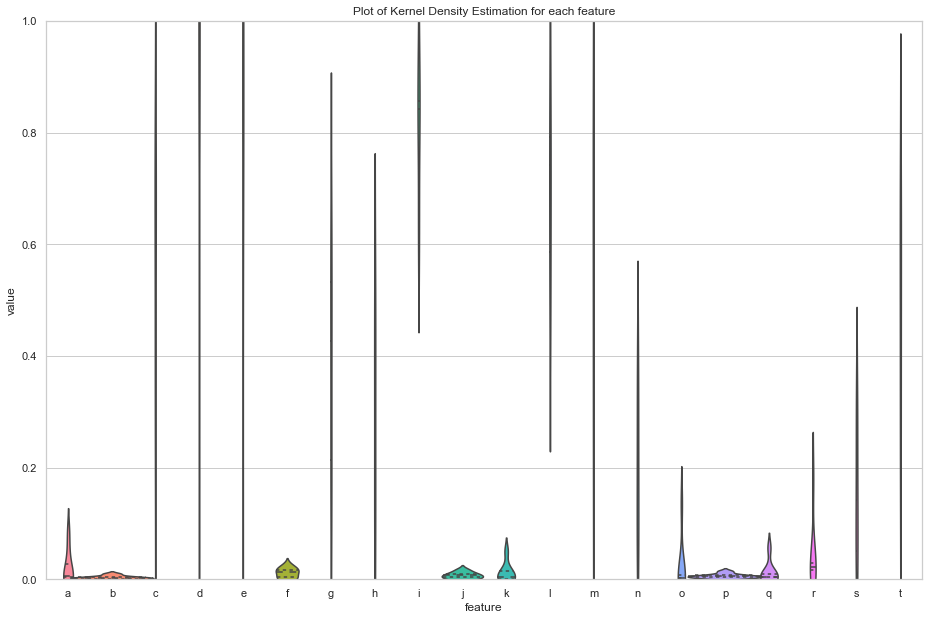

In [47]:
ax = sns.violinplot(x="feature", y="value", data=melted, split=True, width=1.9, inner='quartiles',
                   cut=2, saturation=1, scale="area", orient='v')
ax.set(ylim=(0, 1))
ax.set_title('Plot of Kernel Density Estimation for each feature')

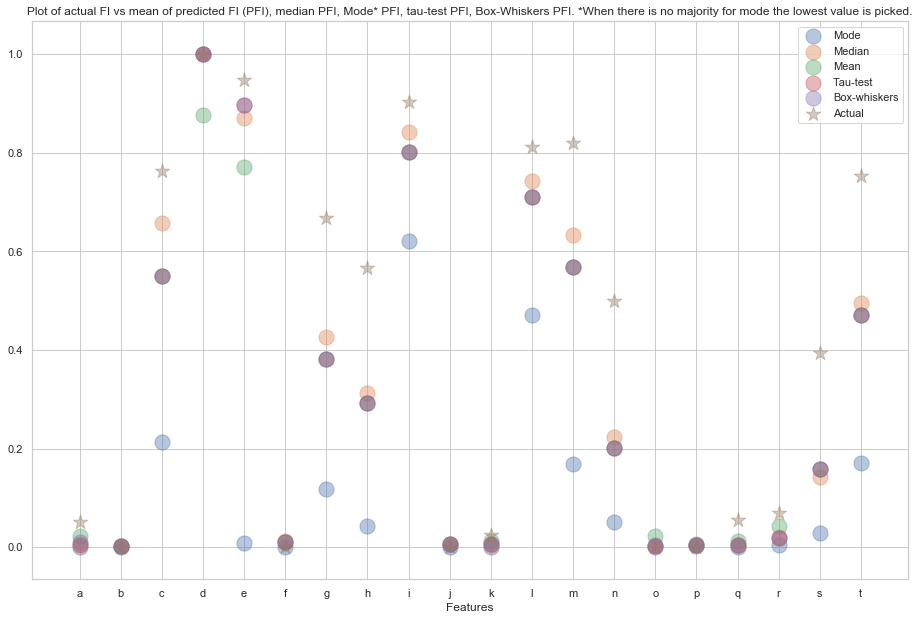

In [51]:
from scipy import stats
total_scaled_mode = stats.mode(all_stacked, axis=1)
total_scaled_mode = np.reshape(total_scaled_mode[0], (-1,1))
# plt.scatter(feature_names,rf_sv_scaled, color='red', label='Actual')
# plt.scatter(feature_names,pi_result_rf_scaled, color='red')
# plt.scatter(feature_names,gb_sv_scaled, color='red')
# plt.scatter(feature_names,pi_result_gb_scaled, color='red')
# plt.scatter(feature_names,dnn_pi_scaled, color='red')
# plt.scatter(feature_names,dnn_sv_scaled, color='red')
# plt.scatter(feature_names,dnn_ig_scaled, color='red')

plt.scatter(feature_names, total_scaled_mode, marker='o', s=230, label='Mode', alpha=0.4)
plt.scatter(feature_names, total_scaled_median, marker='o', s=230, label='Median', alpha=0.4)
plt.scatter(feature_names, total_scaled_mean, marker='o', s=230, label='Mean', alpha=0.4)
plt.scatter(feature_names, total_scaled_tau_test, marker='o', s=230, label='Tau-test', alpha=0.4)
plt.scatter(feature_names, total_scaled_box_whiskers, marker='o', s=230, label='Box-whiskers', alpha=0.4)
plt.scatter(feature_names, scaled_coef,  marker='*', s=230, label='Actual', alpha=0.4)
plt.xlabel('Feature Importance')
plt.xlabel('Features')
plt.title('Plot of actual FI vs mean of predicted FI (PFI), median PFI, Mode* PFI, tau-test PFI, Box-Whiskers PFI. *When there is no majority for mode the lowest value is picked.')
plt.legend(loc='best')
plt.show()

In [ ]:
# Peirce's criterion <- important because its robust statistics
# fuzzy mean
# dbscan
# some form of anomaly detection